<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Multi_Objective_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Objective. Brachistochrone Problem


The Brachistochone is the famous problem to find the shape of the curve down wich a bead sliding from rest and accelerated by gravity will slip (**without friction**) from one point to another in the least time. 

"The shortest path and the shortest time"

## Base Operations

### Necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random as rm
import os
import subprocess
import torch
import torch.optim as optim
import glob
import time
import json
import base64
import csv
  
from IPython.display import display, HTML
from pathlib import Path
from PIL import Image
from datetime import date, datetime
from math import sqrt,sin,cos
from scipy.optimize import fsolve
from random import shuffle, randint
from copy import deepcopy

### Hyperparameters

In [20]:
ga_selection_method = ["Tournament", "NSGA2"]
ga_objectives = ["Time", "Distance"]
ga_n_dimensions = 2
ga_n_individuals = 30
ga_n_generations = 10000
ga_n_points = 15

# Percentage
ga_ps = 0.7 # Selection
ga_pc = 1 # Crossover
ga_pm = 0.3 # Mutation
ga_elite = 0.1 # Selected group that is superior to the rest of a individuals

ga_p_variable = True # Varied the probability

# Boundaries 
ga_xl = 0 # left boundary
ga_xr = 1 # rigth boundary
ga_yu = 1 # up boundary
ga_yl = -1 # low boundary
ga_limits = [ga_xl, ga_yl]
ga_weights = [1, 1] # Time, Distance
ga_height = 1
ga_width = 1

ga_seed = 1

ga_show_info = True # See Important Info
ga_show_debug = False # See Specific info to help the visualization for develop
ga_show_plot = True # See Description Prints
ga_max_frames = 20
ga_parents = []
ga_new_individuals = []

ga_base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA Project/Multi-Objective"
ga_counter = 0
ga_misc_runs_dir = ""
ga_evolution_dir = ""
ga_objectives_dir = ""

date_string = date.today()
base_name = f'Env_({date_string})_ind={ga_n_individuals}_gen={ga_n_generations}_pts={ga_n_points}'

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

### Common Functions

In [21]:
# Set the start config
def initConfig(folder=ga_misc_runs_dir, file='config.json', set_global=False, show_debug=False):
  file = os.path.join(folder, file)

  if Path(file).is_file():
    with open(file, "r") as f:
      myJSON = json.loads(f.read()) # Reading from file
      f.close()
  else:
    globals__ = globals()
    config = {}

    # Inside our Genetic algorithm, we declare all global values as ga_*
    # Easier for search and get all the config values
    for key, value in sorted(globals__.items()):
      if key.startswith('ga_'):
        config[key] = value

    myJSON = json.dumps(config, indent = 4) 

    with open(file, "w") as f:
        f.write(myJSON)
        f.close()

  if ga_show_debug:
    print("\n----------------------------------------------------------------")
    print(f'Configuration: \n{file}')
    print(myJSON)
    print("Write successful")
    print("----------------------------------------------------------------\n")

  if set_global:
    # set_global = False as default, save the new configuration but don't update the global values
    # set_global = True to use the new config from file 
    globals().update(myJSON)


# Create environment Folders
def makeFolders():
  global date_string, base_name, ga_evolution_dir, ga_objective_dir, ga_misc_runs_dir

  date_string = date.today()
  base_name = f'Env_({date_string})_ind={ga_n_individuals}_gen={ga_n_generations}_pts={ga_n_points}'
  ga_evolution_dir = os.path.join(ga_base_path, "evolution/" + base_name)
  ga_objective_dir = os.path.join(ga_base_path, "objectives/" + base_name)
  ga_misc_runs_dir = os.path.join(ga_base_path, "misc_runs/" + base_name)

  Path(ga_evolution_dir).mkdir(parents=True, exist_ok=True)
  Path(ga_objective_dir).mkdir(parents=True, exist_ok=True)
  Path(ga_misc_runs_dir).mkdir(parents=True, exist_ok=True)


# Normalize an array between given min and max values 
def normalize(data, min, max):
  normal = []
  old_min = np.min(data)
  old_max = np.max(data)
  old_range = old_max - old_min
  
  new_min = min
  new_max = max
  new_range = new_max - new_min

  if old_range == 0:            
      if old_min < new_min:      
          new_value = new_min
      elif old_min > new_max:    
          new_value = new_max
      else:                    
          new_value = old_min
      normal = [new_value for value in data]
  else:
      scale = new_range / old_range
      normal = [(value - old_min) * scale + new_min for value in data]

  return normal


# Write data into a CSV
def exportCSV(data, folder=ga_misc_runs_dir, file='data.csv'):
  file = os.path.join(folder, file)

  if not Path(file).is_file():
    with open(file, 'w', encoding='UTF8', newline='') as f:
      writer = csv.writer(f)
      writer.writerows(data) # Write multiple rows
      f.close()


# Read data into CSV and return values from file
def importCSV(folder=ga_misc_runs_dir, file='data.csv'):
  file = os.path.join(folder, file)
  list_points = []

  if Path(file).is_file():
    with open(file, 'r') as f:
      csv_reader = csv.reader(f)
      for line in csv_reader:
        list_points.append(list(line))
      f.close()
  
  return list_points


# Create GIF from folder
def exportGIF(fp_in, fp_out):
  global ga_counter
  ga_counter += 1

  imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=400, loop=0)
  img = Image.open(fp_out)


# Display GIF
def importGIF(folder=ga_evolution_dir, file='gif.gif'):
  file = os.path.join(folder, file)

  if Path(file).is_file():
    with open(file, 'rb') as f:
      b64 = base64.b64encode(f.read()).decode('ascii')
      f.close()
    return display(HTML((f'<img src="data:image/gif;base64,{b64}" />')))
  else:
    return print("File doesn't exist")

# Write data into a TXT
def exportTXT(data, folder=ga_misc_runs_dir, file='logs.txt'):
  file = os.path.join(folder, file)

  with open(file, "w") as f:
    for row in data:
      f.write(row + "\n")
    f.close()

## Genetic Algorithm Components



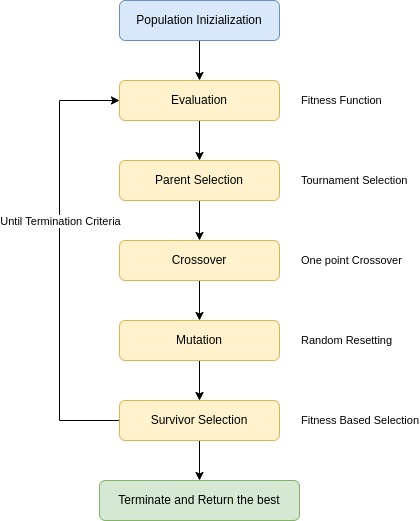

### Initialization


#### Individual

In [5]:
class Individual():
  def __init__(self, 
               n_points=ga_n_points, 
               height=ga_height,
               width=ga_width,
               x=[],
               y=[], 
               random=True):

    self.n_points = n_points
    self.n_segments = n_points-1
    self.width = width
    self.height = height
    self.x = x
    self.y = y

    if random:
      self.generateIndividual()


  # Generate Individual Randomly
  def generateIndividual(self):
    self.y = [self.height]
    self.x = [0]
    self.delta_x = self.width/self.n_segments

    for i in range(self.n_segments-1):
        self.x.append((i+1)*self.delta_x)
        frac = 1
        self.y.append(-self.height/frac + rm.random()*(self.height - (-self.height/frac)))

    self.x.append(self.width)
    self.y.append(0)


#### Population

In [6]:
class Population():
  def __init__(self, 
              individual=Individual, 
              n_individuals=ga_n_individuals,
              objectives=ga_objectives,
              show_plot=False, 
              show_info=False, 
              show_debug=False, 
              **kwargs):
    
    self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
    self.individual = individual
    self.n_individuals = n_individuals
    self.objectives = objectives
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug
    self.random = kwargs.get('random', True)
    
    self.fitness_values = np.zeros((self.n_individuals, len(self.objectives))) # Because of 2 objective functions
    
    if self.random:
      self.list_individuals = [[self.createNewIndivid(**kwargs),0] for i in range(self.n_individuals)]
    else:
      self.list_individuals = [[self.setNewIndivid(i, **kwargs),0] for i in range(self.n_individuals)]

    if self.show_info:
      self.printPopulation()

    if self.show_plot:
      figure, ax = plt.subplots(1,1,  figsize=(6,5))
      self.plotPopulation(ax)
      plt.show()


  # Create New Individual. Randomly Generation 
  def createNewIndivid(self, **kwargs):
    return(self.individual(**kwargs))


  # Create New Individual  
  def setNewIndivid(self, index, **kwargs):
    list_points = kwargs.get('list_points', [])
    n_points = kwargs.get('n_points', 0)
    height = kwargs.get('height', ga_height)
    width = kwargs.get('width', ga_width)

    if (len(list_points) > 0) and (len(list_points) > index):
      x = list_points[index][0]
      y = list_points[index][1]

      if (n_points == 0):
        n_points = len(x)
        
      return(self.individual(n_points=n_points,
                             height=height, 
                             width=width,
                             x=x, 
                             y=y,
                             random=self.random))
    else:
      return(self.individual())


  # General Information of the Population
  def printPopulation(self):
    print("\n--------------------------------")
    print("Population Created")
    print("--------------------------------")
    print("Number of individuals: ", str(self.n_individuals))
    print("Randomly Population Generation: ", str(self.random))
    print("Population Edited Parameters: ", str(self.kwargs_str))
    print("-------------------------------- \n")


  # Plot of the Population
  def plotPopulation(self, ax, **kwargs):
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Population Representation')

    for individual in self.list_individuals:
      ax.plot(individual[0].x, individual[0].y)

### Evaluation

In [7]:
class Fitness():
  def __init__(self, 
              population=Population, 
              weights=ga_weights,
              objectives=ga_objectives,
              selection_method=ga_selection_method[0],
              show_plot=False, 
              show_info=False, 
              show_debug=False):
    
    self.population = population
    self.weights = weights
    self.objectives = objectives,
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

    self.t_ideal = 0 # Ideal Time
    self.d_ideal = 0 # Ideal Distance
    self.sol = []

    individual = self.population.list_individuals[0][0]
    self.maxTime = self.getMaxTime(individual)
    self.maxDistance = self.getMaxDistance(individual)
    self.getBestCurve(individual)


  # Update Population
  def setPopulation(self, population):
    self.population = population


  # Calculation of Objectives and return Fitness Objectives separated
  def getObjectives(self, individual):
    g = 9.8
    v = [0]
    t = []
    l = []

    for i in range(len(individual.y)-1):
      v.append(sqrt(2*g*(individual.y[i] - individual.y[i+1])+v[i]**2))
      l.append(sqrt((individual.x[i] - individual.x[i+1])**2 + (individual.y[i] - individual.y[i+1])**2))
      t.append(l[i] / v[i+1])

    F1 = self.weights[0]*sum(t) # Time
    F2 = self.weights[1]*sum(l) # Distance

    return F1, F2


  # Calculation of unique Fitness Objective
  def getFitness(self, individual):
    F1, F2 = self.getObjectives(individual)
    return F1 + F2


  # Calculation of Fitness Objectives. Return fitness of the entire population
  def getFitnessPopulation(self, sort=False):
    for individual in self.population.list_individuals:
      individual[1] = self.getFitness(individual[0])
      self.population.fitness_values[0], self.population.fitness_values[1] = self.getObjectives(individual[0])

    if sort:
      self.sortIndividuals()

    if self.show_info:
      self.printFitnessFunctions()

    return self.population


  # Sort Individuals by unique Fitness
  def sortIndividuals(self):
    list.sort(self.population.list_individuals, key=lambda fitness: fitness[1])


  # Calculation of the Max Time taken. Calculation of normalization data
  def getMaxTime(self, individual):
    maxTime = sqrt((individual.x[0] - individual.x[-1])**2 + (individual.y[0] - individual.y[-1])**2)
    return maxTime


  # Calculation of the Max Distance taken. Calculation of normalization data
  def getMaxDistance(self, individual):
    maxDistance = (individual.x[-1] - individual.x[0]) + (individual.y[0] - individual.y[-1])
    maxDistance *= individual.n_points
    return maxDistance


  # Calculation of the Ideal Time 
  def getBestCurve(self, individual):
    w = individual.width
    h = individual.height
    sol_numeric_y = []

    f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
    t = fsolve(f_t,3.14)[0]

    a = w/(t-sin(t))

    t_range = np.linspace(0,t,individual.n_points)

    x = lambda t: a*(t-np.sin(t))
    y = lambda t: h + a*(np.cos(t)-1)

    self.sol = (t_range, x, y)

    for x_pt in individual.x:
        f = lambda t: x(t)-x_pt
        tval = fsolve(f,3.14)[0]
        sol_numeric_y.append(y(tval))

    temp_state = individual.y
    individual.y = sol_numeric_y
    individual.sol_numeric_y = sol_numeric_y
    
    self.t_ideal, self.d_ideal = self.getObjectives(individual)
    individual.y = temp_state

    if self.show_info:
      print('\n-------------------------------------')
      print('Theoretical best time:', self.t_ideal, "\n")
      print('Theoretical best distance:', self.d_ideal, "\n")
      print('\n-------------------------------------')


  # General Information of the Fitness
  def printFitnessFunctions(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', self.objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.list_individuals):
      print('Individual {:10}     |    W. Fitness: {:.4f}'.format(index, individual[1]))


  # Plot of an Individual comparison with the Brachistochrone
  def plotState(self, individual, ax, width, height, color='black', plot_sol=False, plot_label=False):
    ax.clear()
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Comparison Actual Result with Brachistochrone')

    if plot_sol:
      t = self.sol[0]
      x = self.sol[1]
      y = self.sol[2]
      ax.plot(x(t), y(t), '-', color='gray')

      if plot_label:
        ax.text(0.7*width, 0.8*height, 'Ideal Time: {:.3f}'.format(self.t_ideal))

    if plot_label:
      time, distance = self.getObjectives(individual)
      ax.text(0.7*width, 0.7*height, 'Current Time: {:.3f}'.format(time))

    ax.plot(individual.x, individual.y, 'o-', color=color)


  # Plot of the Best and Mean Fitness Function
  def plotFitnessFunction(self, ax, best, mean):
    ax.set_xlabel('Generations')
    ax.set_ylabel('Fitness Function')
    ax.set_title('Best and Mean Results')
    ax.plot(best, label='best', color='dodgerblue')
    ax.plot(mean, label='mean', color='tomato')
    ax.legend()
    ax.text(0.6*len(best), 0.8*max(best), 'best: {:.3f}\nmean: {:.3f}'.format(best[-1], mean[-1]))


### Selection

In [8]:
class Selection():
  def __init__(self,
               population=Population, 
               ps=ga_ps,
               show_plot=False,
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.parents = []
    self.ps = ps
    self.quantity_parents = 3

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug


  # Probabilistic Selection
  def getProbabilisticSelection(self):
    probability = np.random.uniform(
        low=0, high=1, size=self.population.n_individuals)
    
    probability = probability <= self.ps
    if sum(probability == True) > 0:
      self.quantity_parents = sum(probability == True)


  # Get All new Parents using Tournament Selection
  def getParentsSelection(self):
    self.getProbabilisticSelection()
    
    for i in range(self.quantity_parents):
      self.parents.append(self.tournamentSelection())

    if self.show_info:
      self.printParents()

    return self.parents


  # We select K individuals from the population at random and select the best 
  # out of these to become a parent
  def tournamentSelection(self):
    parents = rm.choices(self.population.list_individuals, k=5)
    list.sort(parents, key=lambda fitness: fitness[1])

    return (parents[0])


  # General Information of the Parents
  def printParents(self):
    print('\n-------------------------------------')
    print('Selection Parents')
    print('\n')
    for index, individual in enumerate(self.parents):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))


### Crossover

In [9]:
class Crossover():
  def __init__(self, 
               population=Population, 
               parents=ga_parents, 
               pc=ga_pc,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
 
    self.population = population
    self.parents = parents
    self.new_individuals = []
    self.pc = pc

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug


  # Get New Individuals result of the Crossover using One Point Crossover operator
  def getNewIndividuals(self):
    rm.shuffle(self.parents)
    n_couple = int((len(self.parents)-1) / 2)
    for i in range(n_couple+1):
      new_child1, new_child2 = self.onePointCrossover(self.parents[i], self.parents[-(i-1)])
      self.new_individuals.append(new_child1)
      self.new_individuals.append(new_child2)

    if self.show_info:
      self.printNewPopulation()

    return self.new_individuals


  # A random crossover point is selected and the tails of its two parents are 
  # swapped to get new off-springs
  def onePointCrossover(self, parent1, parent2):
    new_child1 = deepcopy(parent1)
    new_child2 = deepcopy(parent2)

    r1 = randint(1,parent1[0].n_points-3)
    r2 = randint(r1+1,parent2[0].n_points-2)

    temp = new_child1[0].y[r1:r2]
    new_child1[0].y[r1:r2] = new_child2[0].y[r1:r2]
    new_child2[0].y[r1:r2] = temp

    return(new_child1, new_child2)


  # Result of the Crossover New Individuals
  def printNewPopulation(self):
    print('\n-------------------------------------')
    print('Crossover New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')


### Mutation

In [10]:
class Mutation():
  def __init__(self, 
               new_individuals=ga_new_individuals, 
               pm=ga_pm,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.new_individuals = new_individuals
    self.pm = pm

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug


  # Small random tweak in the chromosome to get a new solution
  def randomSetMutation(self):
    mutate_individual = []
    mutate_individual.clear()

    for individual in self.new_individuals:
      mutate_individual.append(self.mutate(individual))

    self.new_individuals = mutate_individual
      
    if self.show_info:
      self.printMutation()

    return self.new_individuals


  # Random Resetting operator
  def mutate(self, individual):
    probability = np.random.uniform(
    low=0, high=1, size=individual[0].n_points-2)

    probability = probability <= self.pm

    mutate_individual = deepcopy(individual)
    height = individual[0].height
  
    if sum(probability == True) > 0:
      mutate_individual[0].y = mutate_individual[0].y[1: mutate_individual[0].n_points-1]

      # Mutate Random Process
      for i in np.where(probability)[0]:
        frac = 1
        mutate_individual[0].y[i] = (-height/frac + rm.random()*(height - (-height/frac)))
      
      mutate_individual[0].y = [height] + mutate_individual[0].y + [0]

    return mutate_individual 


  # A random value from the set of permissible values is assigned to a randomly chosen gene
  def mutateSingle(self):
    index = randint(1, self.n_segments-1)
    new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
    
    if new_height < self.height:
      self.y[index] = new_height


  # Result of the Mutation of the New Individuals
  def printMutation(self):
    print('\n-------------------------------------')
    print('Mutation New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')


### Survivor Selection

In [27]:
class Survivor_Selection():
  def __init__(self, 
               population=Population, 
               new_individuals=ga_new_individuals,
               objectives=ga_objectives,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.new_individuals = new_individuals
    self.objectives = objectives
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

    self.new_population = []


  def getNewPopulation(self):
    self.new_population =  self.population.list_individuals + self.new_individuals

    fitness = Fitness(self.population)
    fitness_values = np.zeros((len(self.new_population), len(self.objectives)))

    for i, individual in enumerate(self.new_population):
      fitness_values[i][0], fitness_values[i][1] = fitness.getObjectives(individual[0])
    
    pareto_front_index = []
    pop_index_0 = np.arange((len(self.new_population)))
    pop_index = np.arange((len(self.new_population)))

    while len(pareto_front_index) < self.population.n_individuals:
      new_pareto_front = self.paretoFront(fitness_values[pop_index_0, :], pop_index_0)
      total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

      if total_pareto_size > self.population.n_individuals:
        number_solutions_needed = self.population.n_individuals - len(pareto_front_index)
        selected_population_index = self.removeWithCrowding(fitness_values[new_pareto_front], number_solutions_needed)
        new_pareto_front = new_pareto_front[selected_population_index]
    
      pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
      remaining_index = set(pop_index) - set(pareto_front_index)
      pop_index_0 = np.array(list(remaining_index))

    selected_population_index = [pareto_front_index.astype(int)][0]
    
    self.new_population = [self.new_population[i] for i in selected_population_index]
    self.population.list_individuals = self.new_population
    
    fitness.setPopulation(self.population)
    fitness.getFitnessPopulation()

    self.population = fitness.population

    # Update Fitness on the population
    for i, individual in enumerate(self.population.list_individuals):
      self.population.fitness_values[i][0], self.population.fitness_values[i][1] = fitness.getObjectives(individual[0])

    self.t_best, self.d_best, self.mean = self.getBestandMean()

    if self.show_info:
      self.printSurvivor()

    if self.show_plot:
      figure, ax = plt.subplots(1,1,  figsize=(6,5))
      self.plotParetoFront(ax, fitness_values)
      plt.show()

    return self.population


  # Crowding Distance Calculation
  def crowdingCalculation(self, fitness_values):
    population_size = len(fitness_values[:, 0])
    dimension = len(fitness_values[0, :])
    crowding = np.zeros((population_size, dimension))

    normalize_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0)

    for i in range(dimension):
      crowding_results = np.zeros(population_size)
      crowding_results[0] = 1
      crowding_results[population_size - 1] = 1
      sorting_normalize_fitness_values = np.sort(normalize_fitness_values[:, i])
      sorting_normalized_values_index = np.argsort(normalize_fitness_values[:, i])

      # Crowding Distance Calculation
      crowding_results[1:population_size-1] = (sorting_normalize_fitness_values[2:population_size] - sorting_normalized_values_index[2:population_size])
      re_sorting = np.argsort(sorting_normalized_values_index)
      crowding[:,i] = crowding_results[re_sorting]

    crowding_distance = np.sum(crowding, axis=1) # crowding distance of each solution
    
    return crowding_distance


  # Remove not good values depending on the crowding Distance Calculation
  def removeWithCrowding(self, fitness_values, number_solutions_needed):
    population_index = np.arange(fitness_values.shape[0])
    crowding_distance = self.crowdingCalculation(fitness_values)
    selected_population_index = np.zeros((number_solutions_needed))
    selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))

    for i in range(number_solutions_needed):
      population_size = population_index.shape[0]
      a = rm.randint(0, population_size - 1) # Solution Random 1
      b = rm.randint(0, population_size - 1) # Solution Random 2
      if crowding_distance[a] >= crowding_distance[b]:
        # Solution 1 is better than solution 2
        selected_population_index[i] = population_index[a]
        selected_fitness_values[i, :] = fitness_values[a, :]
        population_index = np.delete(population_index, (a), axis=0)
        fitness_values = np.delete(fitness_values, (a), axis=0)
        crowding_distance = np.delete(crowding_distance, (a), axis=0)

      else:
        # Solution 2 is better than solution 1
        selected_population_index[i] = population_index[b]
        selected_fitness_values[i, :] = fitness_values[b, :]
        population_index = np.delete(population_index, (b), axis=0)
        fitness_values = np.delete(fitness_values, (b), axis=0)
        crowding_distance = np.delete(crowding_distance, (b), axis=0)
    
    selected_population_index = np.asarray(selected_population_index, dtype=int) # Convert the data to integer 
     
    return selected_population_index


  # Creating Pareto Front
  def paretoFront(self, fitness_values, population_index):
    population_size = fitness_values.shape[0]
    # Initially assume all solutions are in pareto front by using "1"
    pareto_front = np.ones(population_size, dtype=bool) 
    for i in range(population_size):
        for j in range(population_size):
                if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                  pareto_front[i] = 0
                  break
    return population_index[pareto_front]


  # Return one of the set of best solutions 
  def getBestandMean(self):
    t_best = self.population.fitness_values[0][0]
    d_best = self.population.fitness_values[0][1]

    mean = sum([individual[1] for individual in self.population.list_individuals])/(1.0*len(self.population.list_individuals))
    return((t_best, d_best, mean))


  # Result of New Population
  def printSurvivor(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', self.objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.list_individuals):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))


  # Ploting Pareto Front
  def plotParetoFront(self, ax, fitness_values, maxX=False, maxY=False):
    ax.set_xlabel(self.objectives[0])
    ax.set_ylabel(self.objectives[1])
    ax.set_title('Pareto Frontier')

    # Pareto frontier selection process
    time = [fitness[0] for fitness in fitness_values]
    distance = [fitness[1] for fitness in fitness_values]

    sorted_list = sorted([[time[i], distance[i]] for i in range(len(time))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    ax.scatter(time, distance)
    x = [pair[0] for pair in pareto_front]
    y = [pair[1] for pair in pareto_front]
    ax.plot(x, y)

## Genetic Algorithm execution

In [12]:
class GeneticAlgorithm():

  # Variable = Variation of the Probability between epochs
  def __init__(self, 
               population=Population, 
               n_generations=ga_n_generations,
               objectives=ga_objectives,
               selection_method=ga_selection_method[0],
               misc_runs_dir=ga_misc_runs_dir,
               evolution_dir=ga_evolution_dir,
               objectives_dir=ga_objectives_dir,
               max_frames=ga_max_frames,
               ps=ga_ps, 
               pc=ga_pc, 
               pm=ga_pm,
               show_plot=False, 
               show_info=False, 
               show_debug=False):   

    self.population = population
    self.n_generations = n_generations
    self.objectives = objectives
    self.selection_method = selection_method
    self.misc_runs_dir = misc_runs_dir
    self.evolution_dir = evolution_dir
    self.objectives_dir = objectives_dir
    self.ps = ps 
    self.pc = pc 
    self.pm = pm
    self.show_plot = show_plot 
    self.show_info = show_info
    self.show_debug = show_debug
    self.max_frames = max_frames
    
    self.parents = []
    self.new_individuals = []

    # Show Plot Best Results
    t_best = []
    d_best = []
    mean = []

    # Save on Logs
    logs = []

    # Preparation of environment folders 
    makeFolders()
    initConfig(folder=self.misc_runs_dir, set_global=False)

    # Divide Images on frames
    if self.n_generations <= self.max_frames:
      interval = [i for i in range(self.n_generations)]
      interval_frames = interval
    else:
      interval = int(self.n_generations/self.max_frames)
      interval_frames = [i*interval for i in range(self.max_frames)]


    start = datetime.now()

    for i in range(self.n_generations):
      fitness = Fitness(self.population)
      self.population = fitness.getFitnessPopulation()
      selection = Selection(self.population, self.ps)
      self.parents = selection.getParentsSelection()
      crossover = Crossover(self.population, self.parents, self.pc)
      self.new_individuals = crossover.getNewIndividuals()
      mutation = Mutation(self.new_individuals, self.pm)
      self.new_individuals = mutation.randomSetMutation()
      survivor_selection = Survivor_Selection(self.population, self.new_individuals)
      self.population = survivor_selection.getNewPopulation()

      t_best.append(survivor_selection.t_best)
      d_best.append(survivor_selection.d_best)
      mean.append(survivor_selection.mean)

      if self.show_info:
        if i in interval_frames:
          logs.append('Generation {}, Current Best Time = {:.3f}, Current Best Distance = {:.3f}, current population size = {}'.format(i, survivor_selection.t_best, survivor_selection.d_best, len(self.population.list_individuals)))
          print(logs[-1])

          if self.show_plot:
            figure, ax = plt.subplots(2, 1, figsize=(6,8))
            plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
              
            # Population Representation
            self.population.plotPopulation(ax[0])
              
            # Pareto Function
            survivor_selection.plotParetoFront(ax[1], self.population.fitness_values)

            # Combine all the operations and display
            ## figure.canvas.draw()
            plt.savefig(f'{self.evolution_dir}/{i}.png')

            plt.show()
            print("\n\n")


    # Generations Finish
    if self.show_info:
      individual = self.population.list_individuals[0][0]

      # Initialise the subplot function using number of rows=2 and columns=2
      figure, ax = plt.subplots(2, 2, figsize=(15,13))
      plt.subplots_adjust(left=0.1,
                  bottom=0.1, 
                  right=0.9, 
                  top=0.9, 
                  wspace=0.4, 
                  hspace=0.4)
        
      # Population Representation
      self.population.plotPopulation(ax[0, 0])
        
      # Pareto Function
      survivor_selection.plotParetoFront(ax[0, 1], self.population.fitness_values)

      # Fitness Function
      fitness.plotFitnessFunction(ax[1, 0], t_best, mean)

      # Best Function
      fitness.plotState(individual, ax[1, 1], individual.width, individual.height, color='tomato', plot_sol=True, plot_label=True)

      plt.savefig(f'{self.misc_runs_dir}/best.png')
      plt.show()

      
    end = datetime.now()

    exportTXT(logs, self.misc_runs_dir)

    print('\n-------------------------------------')
    print("Process Complete")
    print('-------------------------------------\n')
    print("Object Fitness:", *self.objectives, sep=', ')
    print("Best Time", survivor_selection.t_best)
    print("Best Distance", survivor_selection.d_best)
    print("Ideal Time", fitness.t_ideal)
    print("Ideal Distance", fitness.d_ideal)
    print("Number of Generations", self.n_generations)
    print("Time Process: {}".format(end - start))
    print("\n-------------------------------------------\n")

    if self.show_plot:
      print('\n-------------------------------------')
      print("Evolution Representation")
      print('-------------------------------------\n')
      fp_in =  self.evolution_dir + "/*.png"
      fp_out = self.evolution_dir + f'/gif.gif'
      exportGIF(fp_in, fp_out)
      importGIF(self.evolution_dir)

# Test Section

## Population Random Generation


--------------------------------
Population Created
--------------------------------
Number of individuals:  30
Randomly Population Generation:  True
Population Edited Parameters:  n_points=15__height=1__width=1
-------------------------------- 



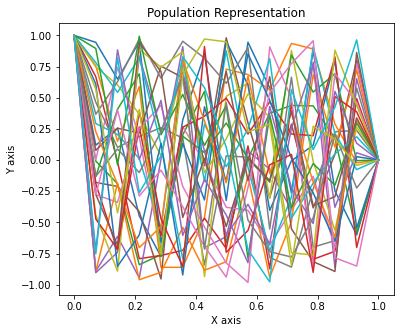

Generation 0, Current Best Time = 1.509, Current Best Distance = 5.184, current population size = 30


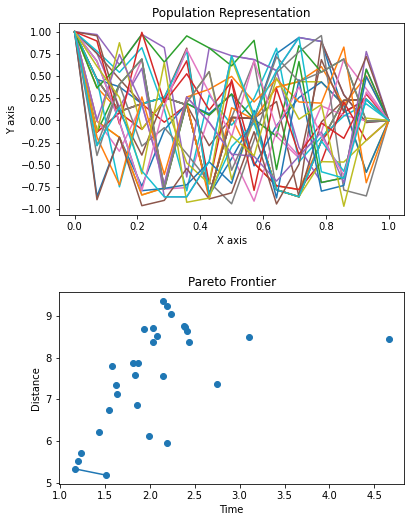




Generation 500, Current Best Time = 0.449, Current Best Distance = 1.670, current population size = 30


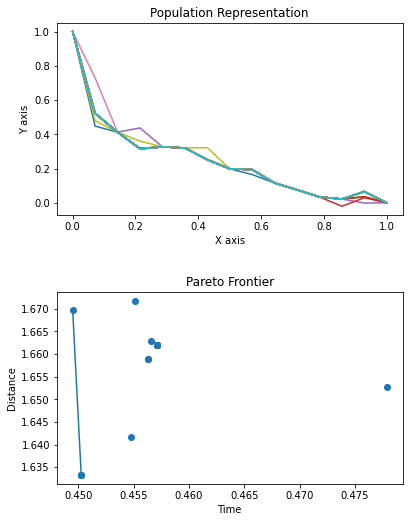




Generation 1000, Current Best Time = 0.446, Current Best Distance = 1.653, current population size = 30


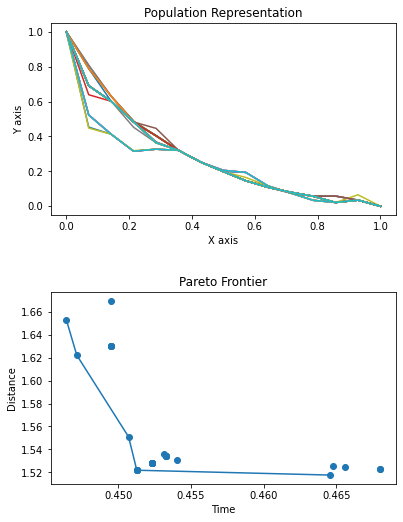




Generation 1500, Current Best Time = 0.449, Current Best Distance = 1.535, current population size = 30


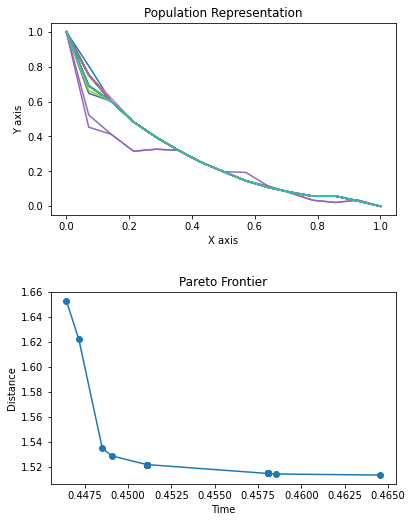




Generation 2000, Current Best Time = 0.459, Current Best Distance = 1.514, current population size = 30


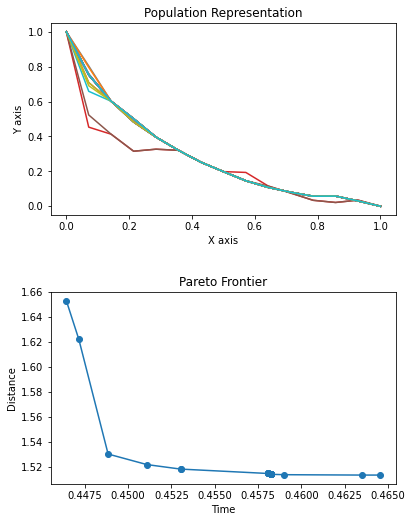




Generation 2500, Current Best Time = 0.458, Current Best Distance = 1.514, current population size = 30


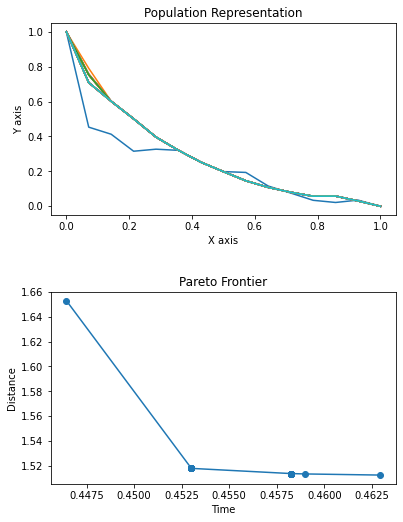




Generation 3000, Current Best Time = 0.458, Current Best Distance = 1.514, current population size = 30


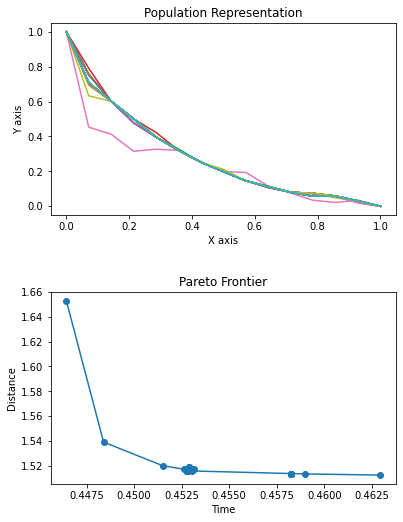




Generation 3500, Current Best Time = 0.454, Current Best Distance = 1.515, current population size = 30


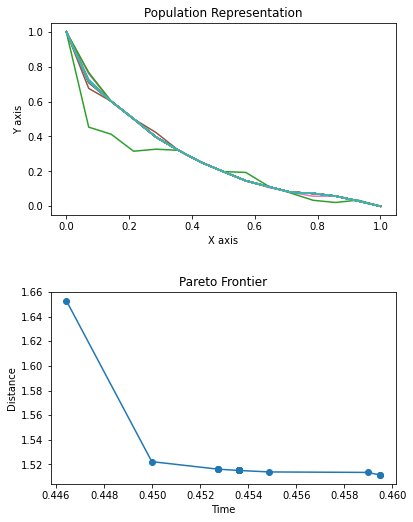




Generation 4000, Current Best Time = 0.454, Current Best Distance = 1.515, current population size = 30


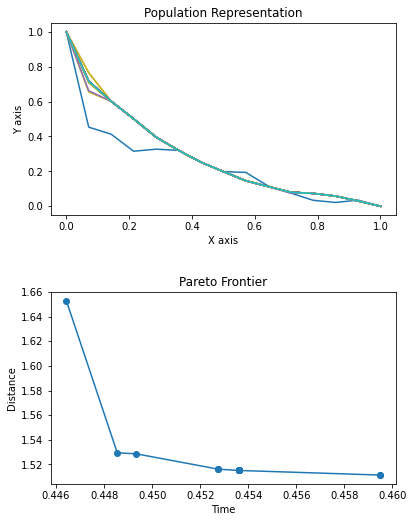




Generation 4500, Current Best Time = 0.453, Current Best Distance = 1.514, current population size = 30


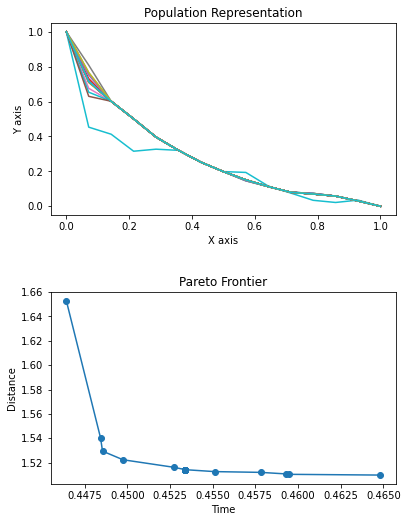




Generation 5000, Current Best Time = 0.453, Current Best Distance = 1.516, current population size = 30


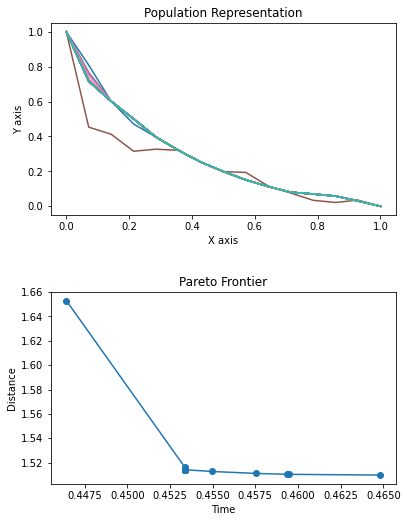




Generation 5500, Current Best Time = 0.446, Current Best Distance = 1.653, current population size = 30


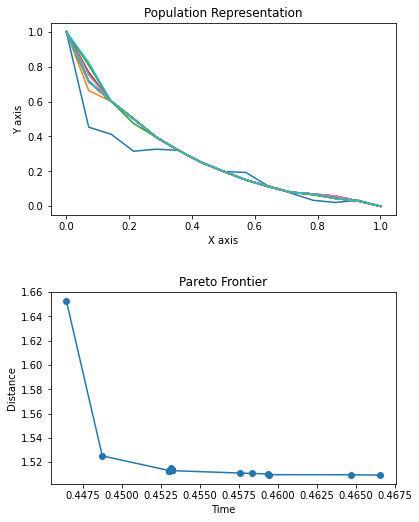




Generation 6000, Current Best Time = 0.465, Current Best Distance = 1.506, current population size = 30


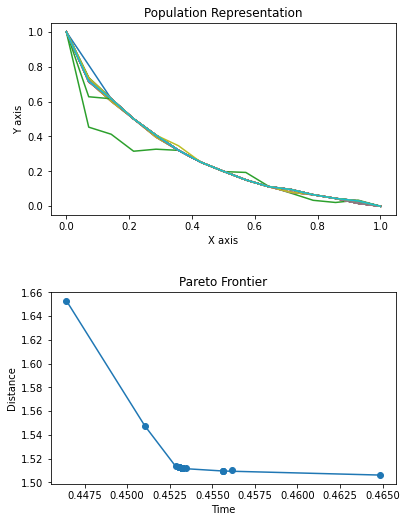




Generation 6500, Current Best Time = 0.453, Current Best Distance = 1.510, current population size = 30


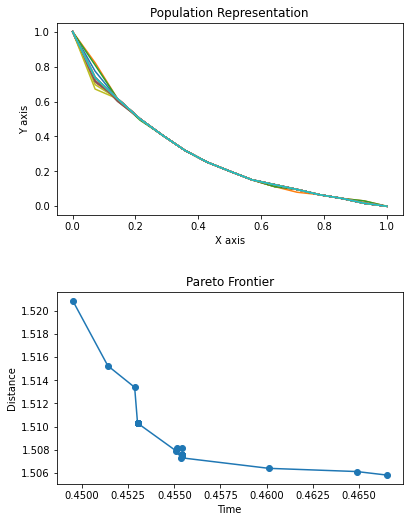




Generation 7000, Current Best Time = 0.455, Current Best Distance = 1.507, current population size = 30


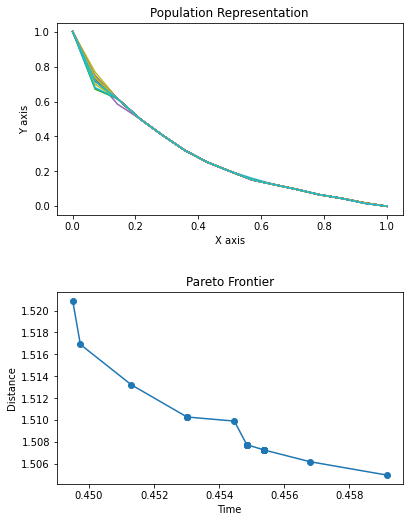




Generation 7500, Current Best Time = 0.450, Current Best Distance = 1.517, current population size = 30


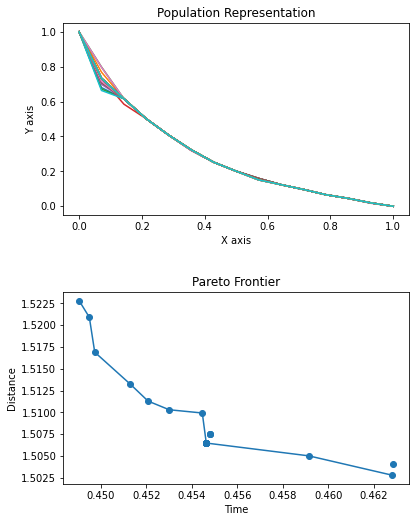




Generation 8000, Current Best Time = 0.455, Current Best Distance = 1.506, current population size = 30


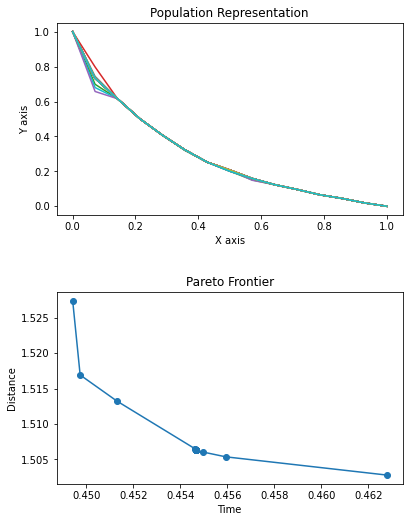




Generation 8500, Current Best Time = 0.455, Current Best Distance = 1.505, current population size = 30


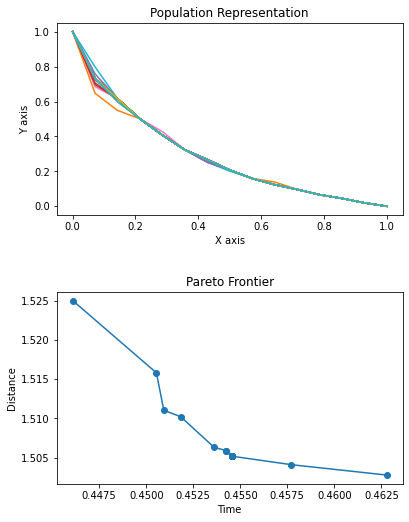




Generation 9000, Current Best Time = 0.461, Current Best Distance = 1.502, current population size = 30


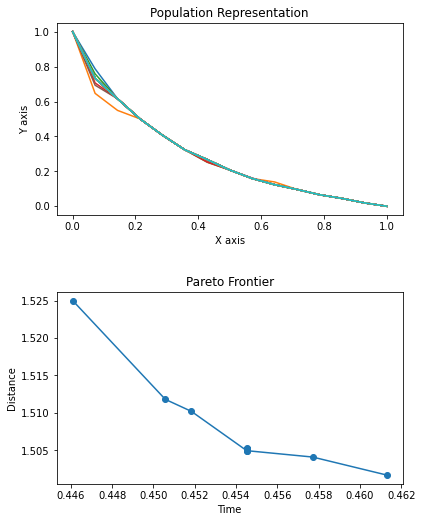




Generation 9500, Current Best Time = 0.461, Current Best Distance = 1.501, current population size = 30


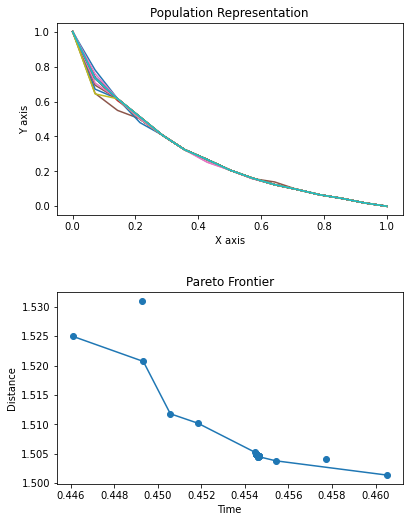

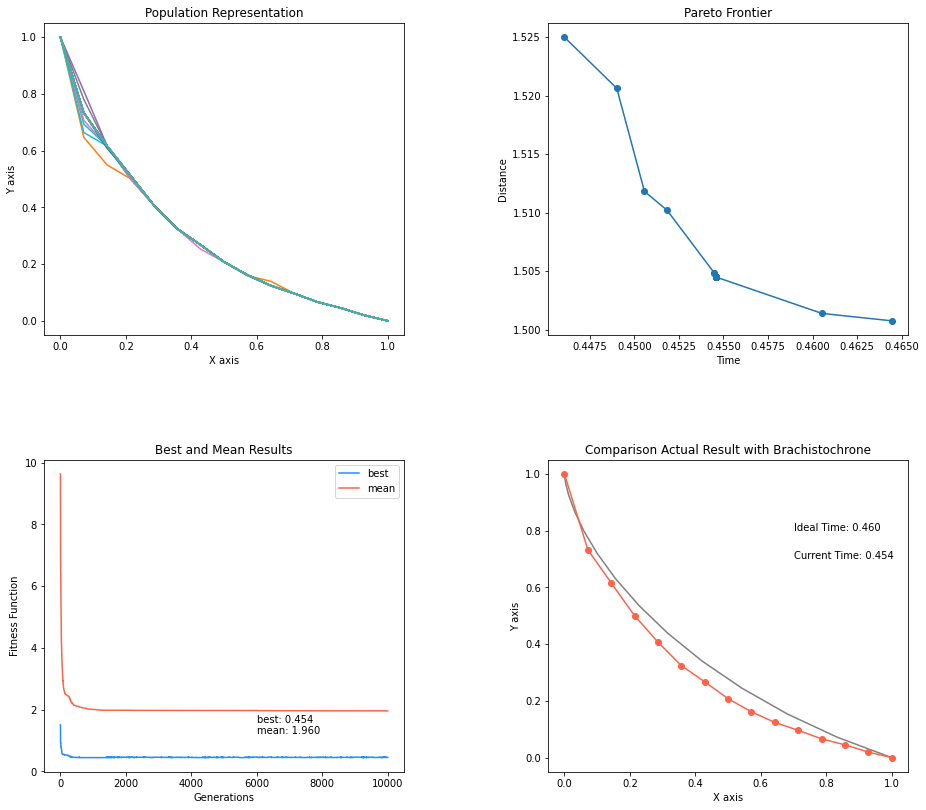


-------------------------------------
Process Complete
-------------------------------------

Object Fitness:, Time, Distance
Best Time 0.45448481471472785
Best Distance 1.5048088341758985
Ideal Time 0.45970521848893153
Ideal Distance 1.4724633226640458
Number of Generations 10000
Time Process: 0:03:05.687923

-------------------------------------------


-------------------------------------
Evolution Representation
-------------------------------------

File doesn't exist


In [28]:
population = Population(Individual, 
                        n_individuals=ga_n_individuals, 
                        n_points=ga_n_points, 
                        height=ga_height, 
                        width=ga_width, 
                        show_plot=ga_show_plot, 
                        show_info=ga_show_info, 
                        show_debug=ga_show_debug)

GeneticAlgorithm(population=population,
                 n_generations=ga_n_generations,
                 objectives=ga_objectives,
                 ps=ga_ps,
                 pc=ga_pc,
                 pm=ga_pm,
                 show_plot=ga_show_plot,
                 show_info=ga_show_info, 
                 show_debug=ga_show_debug)



# Extra